# Using GARCH for Portfolio Management


### Historical / Empirical VaR
Estimates quantiles based on the observed data

### Parametric VaR
Estimates quantiles based on an assumed distribution

Standard VaR calculations have many dsiadvantages. Historical primarily suffers from that it can only tell you the Value at Risk based on historical data, nothing more. Parametric assumes that returns are following some distribution, which in some periods can, and in others wont. For example, it is well known that the returns have fatter tails then accounted for in a normal distribution.

Statistics pulled arbitrarily from a period of low volatility, for example, may understate the potential for risk events to occur and the magnitude of those events.

Simulating future VaR with GARCH can rectify some of these issues, namely that it can forecast the variance in a much more predictable manner. For example, GARCH models can account for black swan events and aysmmetric shocks etc.



### With GARCH
1. Apply GARCH model to make variance forecasts
2. Obtain GARCH mean and volatility estimates
3. Compute qunatile for given level




In [46]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import scipy.stats as stats

from arch import arch_model
from pylab import rcParams 

from arch.__future__ import reindexing
reindexing = True



[*********************100%%**********************]  1 of 1 completed


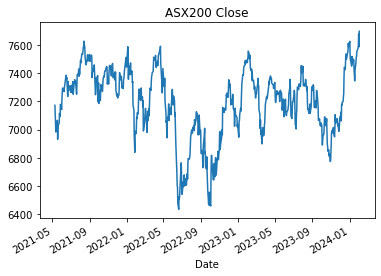

In [33]:
#Setting some arbitrary time period

end = dt.datetime.now()
start =end - dt.timedelta(days=1000)

# Importing some stock data
df = pdr.get_data_yahoo('^AXJO', start, end)

#print(df.head())


adjusted_close = df['Close']
adjusted_close.plot()
plt.title('ASX200 Close')
plt.show()


In [36]:
### Calculating returns
df['return'] = 100*(df['Close'].pct_change())

df['lnReturn']  =np.log(df['Close']/df['Close'].shift(1)).dropna()
df = df.dropna()

# Daily SD of returns
sd_daily = df['return'].std()

# Daily to Monthly vol
sd_monthly = np.sqrt(21) * sd_daily

# daily to annual
sd_annual = np.sqrt(252) * sd_daily

print(f'Daily volatility: {round(sd_daily,2)}%')
print(f'\nMonthly volatility: {round(sd_monthly,2)}%')
print(f'\nAnnual volatility: {round(sd_annual,2)}%')

Daily volatility: 0.83%

Monthly volatility: 3.8%

Annual volatility: 13.15%


### Parametric VaR

In [30]:
enddate = df.index.max()

egarch_gm = arch_model(df['return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
res = egarch_gm.fit(disp='off', last_obs='2022-01-01')


In [31]:
forecasts = res.forecast(start='2023-01-01')
cond_mean = forecasts.mean['2023':]
cond_var = forecasts.variance['2023':]
q = egarch_gm.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

[-2.47635846 -1.61996506]


In [25]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,254.000000,254.000000
mean,2.025230,1.167976
std,0.607721,0.351335
min,0.599679,0.343839
25%,1.622629,0.935225
50%,1.989150,1.147117
75%,2.398880,1.383989
max,4.146921,2.394564


### Empircal VaR

In [38]:
# Specify GARCH model assumptions
basic_gm = arch_model(df['return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 0)


# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

Optimization terminated successfully    (Exit mode 0)
            Current function value: 828.3205778524829
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11


In [39]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q = gm_std_resid.quantile([.01, .05])
print(q)

0.01   -2.906972
0.05   -2.052204
dtype: float64


In [40]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

,1%,5%
count,275.000000,275.000000
mean,-0.079685,-0.080271
std,0.000283,0.000200
min,-0.081679,-0.081679
25%,-0.079842,-0.080382
50%,-0.079703,-0.080284
75%,-0.079548,-0.080175
max,-0.079008,-0.079794


## GARCH and Covariance

In [87]:
end = dt.datetime.now()
start =end - dt.timedelta(days=1500)

# Importing some stock data
FLT = pdr.get_data_yahoo('FLT.AX', start, end)

QAN = pdr.get_data_yahoo('QAN.AX', start, end)

VAS = pdr.get_data_yahoo('VAS.AX', start, end)





[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [88]:
# calculate returns for each
FLT['return']=FLT['Close'].pct_change().dropna()
FLT = FLT.dropna()

QAN['return']=QAN['Close'].pct_change().dropna()
QAN = QAN.dropna()

VAS['return']=VAS['Close'].pct_change().dropna()
VAS = VAS.dropna()


In [89]:
import pmdarima as pm # for auto arima

In [90]:
flt_arima =pm.auto_arima(FLT['return'],seasonal=False,information_criterion='bic',error_action='ignore')

qan_arima =pm.auto_arima(QAN['return'],seasonal=False,information_criterion='bic',error_action='ignore')


vas_arima =pm.auto_arima(VAS['return'],seasonal=False,information_criterion='bic',error_action='ignore')


In [91]:
print(flt_arima)
print(qan_arima)
print(vas_arima)

 ARIMA(1,0,1)(0,0,0)[0]          
 ARIMA(1,0,0)(0,0,0)[0]          
 ARIMA(1,0,0)(0,0,0)[0]          


In [92]:
fltARIMA = sm.tsa.SARIMAX(endog=FLT['return']*100,order=(0, 0, 0))
fltARIMA_result = fltARIMA.fit()

egarch_flt = arch_model(fltARIMA_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
flt_gm_result = egarch_flt.fit(disp = 'off')

###################

qanARIMA = sm.tsa.SARIMAX(endog=QAN['return']*100,order=(0, 0, 0))
qanARIMA_result = qanARIMA.fit()

egarch_qan = arch_model(qanARIMA_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
qan_gm_result = egarch_qan.fit(disp = 'off')

#######################

vasARIMA = sm.tsa.SARIMAX(endog=VAS['return']*100,order=(0, 0, 0))
vasARIMA_result = vasARIMA.fit()

egarch_vas = arch_model(vasARIMA_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
vas_gm_result = egarch_vas.fit(disp = 'off')


C:\Users\New User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\New User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\New User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\New User\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freq

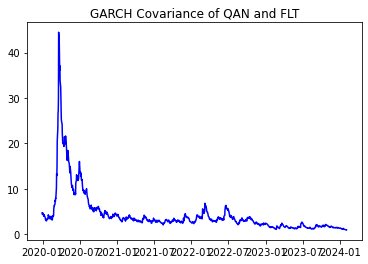

In [94]:
#### Grab all the volatility for each series
vol_flt = flt_gm_result.conditional_volatility
vol_qan = qan_gm_result.conditional_volatility
vol_vas = vas_gm_result.conditional_volatility

#### Standardized residuals
resid_flt = flt_gm_result.resid/vol_flt
resid_qan = qan_gm_result.resid/vol_qan
resid_vas = vas_gm_result.resid/vol_vas

#### Correlation between QAN and FLT

corr = np.corrcoef(resid_qan,resid_flt)[0,1]

#### GARCH covar between QAN and FLT
covar = corr * vol_qan * vol_flt



#plot
plt.plot(covar,color='blue')
plt.title('GARCH Covariance of QAN and FLT')
plt.show()









### Find Best Weights using Sharpe Ratio
The Sharpe ratio seeks to characterize how well the return of an asset compensates the investor for the risk taken. 
 $$S_{a}=\frac{E[R_a - R_r]}{\sigma_{a}}=\frac{E[R_a - R_r]}{\sqrt{Var(R_a - R_r)}}$$
It represents the additional amount of return that an investor receives per unit of increase in risk

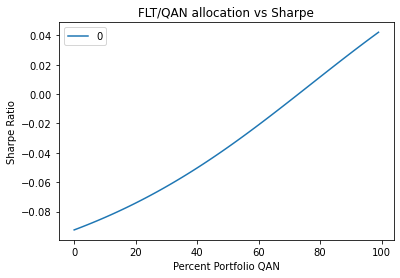

Optimal QAN Weight = 99
Optimal FLT Weight = 1
Optimal Sharpe Ratio = 0.04217868444781163


In [97]:
data = {}
for perc in range(100):
    daily = (1 - perc / 100) * FLT["return"] + (perc / 100) * QAN["return"]
    data[perc] = daily.mean() / daily.std() * (252 ** 0.5)
    
sx = pd.Series(data)
s = pd.DataFrame(sx, index=sx.index)
ax = s.plot(title="FLT/QAN allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio QAN")
plt.show()

tmf_w = 100 - s.idxmax()[0]
print('Optimal QAN Weight =', s.idxmax()[0])
print('Optimal FLT Weight =', tmf_w)
print('Optimal Sharpe Ratio =', s.max()[0])

This is telling us that FLT is returning almost no return for the additional risk taken for it. Thus if it HAS to be in the portfolio, then the optimal weight is =< 1%

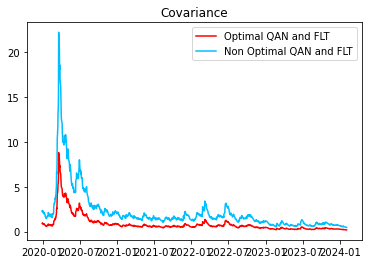

In [104]:
# Define weights
Wa1 = 0.99
Wa2 = 0.1

Wb1 = 0.49
Wb2 = 1 - Wb1

# Calculate individual returns variance
variance_QAN = np.var(QAN['return'])
variance_FLT = np.var(FLT['return'])

# Calculate portfolio variance (variance formula for 2 assets)
portvar_a = Wa1**2 * variance_QAN + Wa2**2 * variance_FLT + 2*Wa1*Wa2*covar
portvar_b = Wb1**2 * variance_QAN + Wb2**2 * variance_FLT + 2*Wb1*Wb2*covar

# Plot the data
plt.plot(portvar_a, color = 'red', label = 'Optimal QAN and FLT')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Non Optimal QAN and FLT')
plt.title('Covariance')
plt.legend(loc = 'best')
plt.show()

## Beta
$$Beta=\rho \frac{\sigma_{stock}}{\sigma_{market}}$$

In [105]:
# 1). Compute correlation between S&P500 and stock
resid_stock = qan_gm_result.resid / qan_gm_result.conditional_volatility
resid_VAS = vas_gm_result.resid / vas_gm_result.conditional_volatility

correlation = np.corrcoef(resid_stock, resid_VAS)[0, 1]

# 2). Compute dynamic Beta for the stock
stock_beta = correlation * (qan_gm_result.conditional_volatility / vas_gm_result.conditional_volatility)

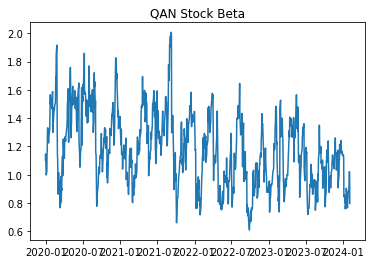

In [106]:
# Plot the Beta
plt.title('QAN Stock Beta')
plt.plot(stock_beta)
plt.show()
